###### Bibliotecas

In [ ]:
!pip install -U kora

     |████████████████████████████████| 57 kB 3.0 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 


In [ ]:
!pip install spicy

In [ ]:
import numpy as np
import math
import statistics as st
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import glob
from PIL import Image
from google.colab import files
import imageio
import moviepy.editor as mp
from kora.drive import upload_public
import time
from scipy.stats import norm

from IPython.display import HTML, display
from IPython.display import clear_output
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
out = display(progress(0, 5000), display_id=True)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2007040/45929032 bytes (4.4%)5177344/45929032 bytes (11.3%)8282112/45929032 bytes (18.0%)12533760/45929032 bytes (27.3%)16531456/45929032 bytes (36.0%)20512768/45929032 bytes (44.7%)24412160/45929032 bytes (53.2%)28524544/45929032 bytes (62.1%)32727040/45929032 bytes (71.3%)36519936/45929032 bytes (79.5%)40583168/45929032 bytes (88.4%)44507136/45929032 bytes (96.9%)

# Gráfico de Controle

## Introdução

Gráficos de controle do tipo $x̄$ são muito úteis para análise de uma produção. Eles lançam mão do Teorema do Limite Central do Limite, que afirma que quando o tamanho da amostra aumenta, a distribuição amostral da sua média aproxima cada vez mais da distribuição normal.

A aplicação disso numa linha de produção é justamente tomar a medida média de uma amostra de 5 itens por vez, de forma a entender se o processo está sob controle estatístico ou não.

Para visualizar isso, é comum utilizar os gráficos de controle, onde traça-se três linhas horizontais, uma contendo o *Limite Superior de Controle*, outra é o *Limite Inferior de Controle* e, entre elas, a linha contendo a média.

## Limites de Controle

É convencionado utilizar para os limites de controle o valor de mais e menos 3 vezes o desvio padrão de um conjunto de amostras. Iremos calcular tudo isso a seguir.

## Simulando Amostragem



Vai ser muito útil à análise presente simular uma situação de produção por meio de um código que gere valores aleatórios. Aqui será simulada uma operação de embalagem de milhos de pipoca, contendo 500$g$ em cada pacote.

Podemos definir uma função genérica para utilizar quando necessário:

In [ ]:
def amostragem(conteudoNominal=500,n=5,dp=1.0):
  a = np.random.normal(size=n,scale = dp)
  a = a+conteudoNominal
  a = np.round(a,2)
  x = np.round(np.mean(a),2)
  amplitude = max(a)-min(a)
  r = {"mediaAmostral" : x,
       "amplitude" : amplitude,
       "amostra" : a.tolist()}
  return r

In [ ]:
amostra = amostragem()
amostra

{'amostra': [499.09, 499.59, 499.53, 501.57, 499.38],
 'amplitude': 2.480000000000018,
 'mediaAmostral': 499.83}

Aqui temos, portanto, uma variável contendo as informações relevantes sobre uma amostragem de $n=5$ elementos. Sento estas informações:
* Média Amostral (`"mediaAmostral"`);
* Amplitude da Amostra (`"amplitude"`);
* Valores da amostra (`"amostra"`).

Avançando mais, podemos fazer um loop de várias amostras para estabelecer os valores necessários posteriormente ao gráfico de controle.

In [ ]:
numeroAmostra = 1000000
muitasAmostras = []
muitasAmostras_amplitude = []
for i in range(0,numeroAmostra):
  muitasAmostras.append(amostragem()["mediaAmostral"])
  muitasAmostras_amplitude.append(amostragem()["amplitude"])

In [ ]:
media = np.round(np.mean(muitasAmostras),3)
desvioPadrao = st.stdev(muitasAmostras)

print("Média de ",numeroAmostra," amostras: ", media)
print("Desvio Padrão: ", np.round(desvioPadrao,4))

limSup = media+(3*desvioPadrao)
limInf = media-(3*desvioPadrao)
lim = {"limSup":limSup,
       "limInf":limInf}
print(lim)

Média de  1000000  amostras:  500.0
Desvio Padrão:  0.4473
{'limSup': 501.34181306261866, 'limInf': 498.65818693738134}


Percebemos que para 1 milhão de amostras, a média é de $500$ com o desvio padrão de $0,4476$. Produzindo os limites superior e inferior conforme declarados acima.

Podemos plotar essas amostras no gráfico e ver quando uma distribuição está sob o devido controle estatístico qual é a cara dela:

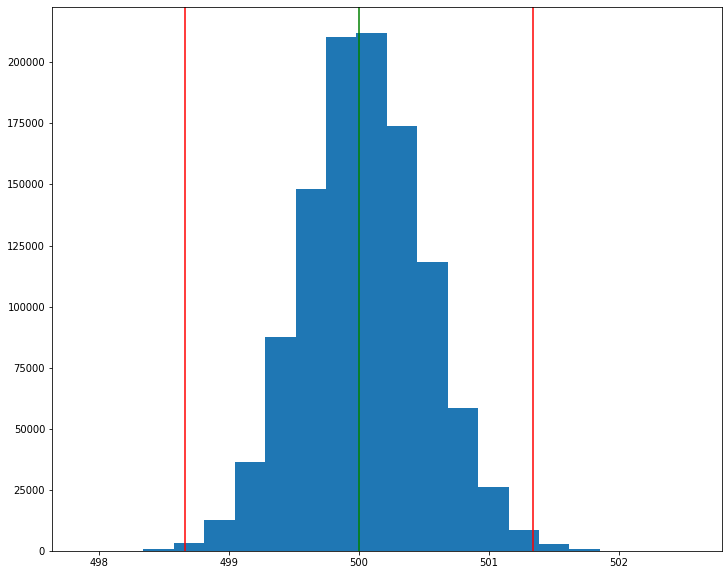

In [ ]:
matplotlib.pyplot.hist(muitasAmostras, bins=20)
plt.axvline(x=500,color="green")
plt.axvline(x=limSup,color="red")
plt.axvline(x=limInf,color="red")

Podemos calcular agora exatamente qual a porcentagem de valores é compreendido pelo limite superior e inferior estipulado pela fórmula anterior:

In [ ]:
filtro = filter(lambda amostra: amostra < limSup, muitasAmostras)
filtro = filter(lambda amostra: amostra > limInf, filtro)
filtro = list(filtro)
print(len(filtro)/len(muitasAmostras)*100,"%")

99.735 %


## Análise da Amplitude para construção do Gráfico de $R$

Existe uma outra forma de estimar os limites superior e inferior de um gráfico de controle. Nele, medimos a amplitude dentro das amostras, chamada de $R$ e depois utilizamos a média dessas amplitudes, $R̄$ ($R$ barra). Pegamos então este valor e dividimos por um valor tabelado em função do número de amostras dentro da amostra considerada, no nosso caso $n = 5$. Após isso, pegamos o quociente da divisão anterior e dividimos por $ \sqrt{n} $.

In [ ]:
rBarra = np.mean(muitasAmostras_amplitude)
desvioPadraoEst = rBarra/(2.326*np.sqrt(5))
desvioPadraoAmplitude = st.stdev(muitasAmostras_amplitude)

In [ ]:
print(np.round(desvioPadraoEst, 5), np.round(desvioPadrao, 5))

0.44728 0.44727


In [ ]:
print(desvioPadraoAmplitude)

0.8646816388315685


Podemos perceber que o valor é extremamente próximo, portanto a aproximação ou estimativa geralmente considera é suficiente para fins práticos. Todavia, como aqui temos acesso à distribuição utilizada, continuaremos com o desvio padrão calculado da forma usual, mas de toda forma, poderia se considerar o desvio estimado através, portanto, de:

>$\hat{\sigma }\:=\:\frac{\bar{R}}{d_2\sqrt{n}}$

De forma análoga, vamos estudar a estimativa e o valor real para os limites superior e inferior do gráfico das amplitudes:

In [ ]:
rBarraIntervaloEst = 0.864*3*rBarra/2.326
rBarraIntervalo = 3*desvioPadraoAmplitude

print(np.round(rBarraIntervaloEst, 5), np.round(rBarraIntervalo, 5))


2.5924 2.59404


Podemos então definir os limites do gráfico de controle das amplitudes através de:

In [ ]:
limSupAmp = rBarra+rBarraIntervalo
limInfAmp = rBarra-rBarraIntervalo

if limInfAmp<0.0:
  limInfAmp = 0.0

print(limSupAmp,limInfAmp)

4.920403276494705 0.0


## Criando uma série para Plotar o Gráfico de Controle

Precisaremos criar uma maneira de manter uma lista de 25 itens de forma a montar o gráfico de controle e fazê-lo caminhar conforme a amostragem é feita. Primeiro declaramos uma lista com 25 médias amostrais e depois criamos uma função para  inserir uma nova amostra ao final da lista sempre que for chamada.

In [ ]:
serie = []
for i in range(0,25):
  serie.append(amostragem()["mediaAmostral"])

serieAmp = []
for i in range(0,25):
  serieAmp.append(amostragem()["amplitude"])

In [ ]:
def novaAmostra(serie, conteudoNominal=500,dp=1.0):
  serie.insert(25, amostragem(conteudoNominal,dp=dp)["mediaAmostral"])
  r = serie[1:25]
  return r

def novaAmostraAmp(serie,conteudoNominal=500,dp=1.0):
  serie.insert(25, amostragem(conteudoNominal,dp=dp)["amplitude"])
  r = serie[1:25]
  return r  

In [ ]:
serie = novaAmostra(serie)
print(serie)

[500.45, 500.55, 500.07, 499.88, 499.62, 500.13, 500.25, 500.17, 500.08, 500.1, 500.74, 500.37, 500.47, 500.5, 499.61, 499.52, 500.8, 499.39, 499.78, 500.54, 499.48, 499.3, 499.65, 499.9]


In [ ]:
def novaAmostraGlobal(serie, serieAmp, conteudoNominal=500,dp=1.0):
  nv = amostragem(conteudoNominal=conteudoNominal,dp=dp)
  serie.insert(25, nv["mediaAmostral"])
  serieAmp.insert(25, nv["amplitude"])
  nvSerie = serie[1:25]
  nvSerieAmp = serieAmp[1:25]
  d = {"mediaAmostral" : nvSerie,
       "amplitude" : nvSerieAmp}
  return d

In [ ]:
nvSerie = novaAmostraGlobal(serie,serieAmp)
serie = nvSerie["mediaAmostral"]
serieAmp = nvSerie["amplitude"]

Podemos agora, pela primeira vez, plotar um gráfico de controle:

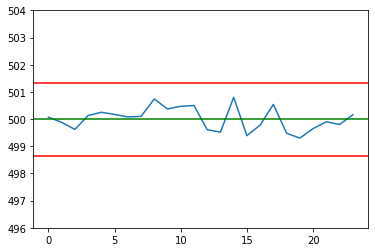

In [ ]:
serie = novaAmostra(serie)
s = pd.Series(serie)
s.plot(use_index=False,ylim=(496,504))
plt.axhline(y=500,color="green")
plt.axhline(y=limSup,color="red")
plt.axhline(y=limInf,color="red")

Vamos agora avançar um pouco na plotagem e inserir, também o gráfico de amplitude logo abaixo do gráfico com a média:

Para criar o gráfico de controle animado, que se move como seria em um chão de fábrica, primeiro precisamos criar uma estrutura de repetição que avance em um número de $n$ amostras no tempo. Fazendo isso para um $n=100$:

### Gráfico de $X̄$ e $R̄$

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

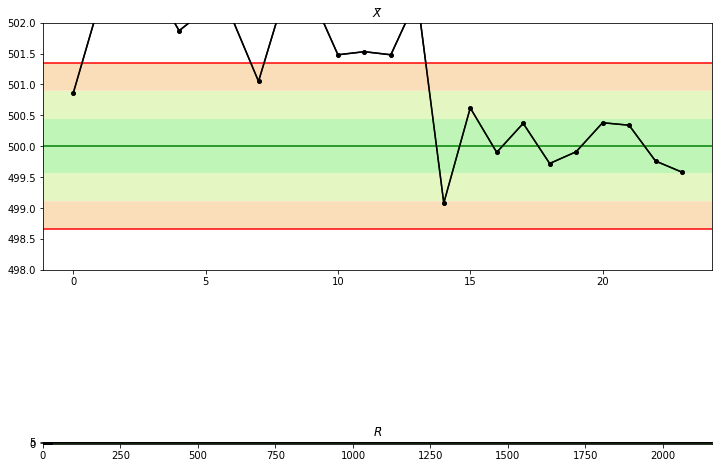

In [ ]:
plt.rcParams["figure.figsize"] = (12,10)
fig, axs = plt.subplots(2)

serie = []
serieAmp = []
for i in range(0,25):
  nv = amostragem()
  serie.append(nv["mediaAmostral"])
  serieAmp.append(nv["amplitude"])

filenames=[]
out = display(progress(0, 100), display_id=True)


for k in range(0,100):
  plt.clf()
  fig, axs = plt.subplots(2)
  print(k)

  # declarando momento em q processo perde o controle:
  if k>10 and k<20:
    nvSerie = novaAmostraGlobal(serie,serieAmp,conteudoNominal=500,dp=2.0)
    plt.legend("Amostra Fora de Controle")
  if k>70 and k<90:
    nvSerie = novaAmostraGlobal(serie,serieAmp,conteudoNominal=502,dp=1.5)
  else:
    nvSerie = novaAmostraGlobal(serie,serieAmp)
  plt.title("Amostra Fora de Controle")  
  # colocar esta parte como comentário quando usar a linha para tirar o processo de controle
  # nvSerie = novaAmostraGlobal(serie,serieAmp)
  serie = nvSerie["mediaAmostral"]
  serieAmp = nvSerie["amplitude"]

  s = pd.Series(serie)
  clear_output(wait=True)
  s.plot(ax = axs[0], use_index=False,ylim=(498,502),color="black")


  # plotando zonas:
  #zona C:
  axs[0].axhline(y=500,color="#2ee312",linewidth=54,alpha=.3)

  #zona B:
  axs[0].axhline(y=499.99+3/2*desvioPadrao,color="#a6e637",linewidth=28,alpha=.3)
  axs[0].axhline(y=500.01-3/2*desvioPadrao,color="#a6e637",linewidth=28,alpha=.3)

  #zona A:
  axs[0].axhline(y=500-5/2*desvioPadrao,color="#f0901a",linewidth=27.58,alpha=.3)
  axs[0].axhline(y=500+5/2*desvioPadrao,color="#f0901a",linewidth=27.58,alpha=.3)


  axs[0].axhline(y=500,color="green")
  axs[0].axhline(y=limSup,color="red")
  axs[0].axhline(y=limInf,color="red")
  s.plot(ax = axs[0], use_index=False,ylim=(498,502),color="black")

  for p in range(0,len(serie)):
    axs[0].plot(p,serie[p],marker="o",markersize=4,color="black")

  # plotando agora o gráfico de R
  serieAmp = novaAmostraAmp(serieAmp)

  r = pd.Series(serieAmp)
  clear_output(wait=True)
  r.plot(ax = axs[1], use_index=False,ylim=(-1,6),color="black")

  # plotando zonas:
  #zona C:
  axs[1].axhline(y=rBarra,color="#2ee312",linewidth=54,alpha=.3)

  #zona B:
  axs[1].axhline(y=rBarra-0.07+3/2*desvioPadraoAmplitude,color="#a6e637",linewidth=31.7,alpha=.3)
  axs[1].axhline(y=rBarra/2,color="#2ee312",linewidth=29,alpha=.3)

  #zona A:
  axs[1].axhline(y=(rBarra/6)-0.02,color="#2ee312",linewidth=28.2,alpha=.3)
  axs[1].axhline(y=rBarra-0.035+5/2*desvioPadraoAmplitude,color="#f0901a",linewidth=31.2,alpha=.3)


  axs[1].axhline(y=rBarra,color="green")
  axs[1].axhline(y=limSupAmp,color="red")
  axs[1].axhline(y=limInfAmp,color="black")
  r.plot(ax = axs[1], use_index=False,ylim=(-1,6),color="black")

  for p in range(0,len(serieAmp)):
    axs[1].plot(p,serieAmp[p],marker="o",markersize=4,color="black")

  axs[0].title.set_text("$X̄$")
  axs[1].title.set_text("$R̄$")

  # plt.pause(.5)
  amostra = 500-serie[len(serie)-1]

  # Controles do Processo:

  # se um ponto estiver fora do limSup e limInf:
  # if amostra > (desvioPadrao*3) or amostra < (-desvioPadrao*3):
  #   print("Amostra fora do intervalo de 3 desvios padrões!")
  #   print("Média amostral: ", 500-amostra)
  #   print("Processo saiu de controle na amostra: ",k)
  #   break

  plt.savefig("/content/amostra_"+str(k)+".png",dpi=180)
  nome="/content/amostra_"+str(k)+".png"
  filenames.append(nome)
  out.update(progress(k+1, 100))

clear_output(wait=True)
print("Imagens finalizadas.")
print("Gerando animação...")
t = len(filenames)
i = 0
with imageio.get_writer('serie.gif',duration=0.8) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        out.update(progress(i+1, t))
        i+=1
plt.imshow(mpimg.imread("/content/serie.gif"))

clip = mp.VideoFileClip("serie.gif")
clip.write_videofile("serie.mp4")

url = upload_public('serie.mp4')
clear_output(wait=True)
HTML(f"""<video src={url} width=800 controls/>""")


# Erros de Decisão

### Alarme Falso




A probabilidade associada ao alarme falso é, nas estatística, a chance de um Erro Tipo I. Cometer este erro é considerar erroneamente o processo fora de controle quando ele na verdade se encontrava ainda sob controle estatístico; em outras palavras: a chance de intervir na hora errada.

Estatísticamente, este erro é conotado como $α$ e é calculado através da distribuição $Z$:

> $\alpha \:=\:P\left\{Z\:>\frac{LSC-\mu }{\sigma }\right\}\:+\:P\left\{Z\:<\:\frac{LIC\:-\:\mu }{\sigma }\right\}$

Para descobrirmos, portanto, qual é essa probabilidade de que qualquer ponto exceda os limites de controle, podemos utilizar o código:

In [ ]:
alfa = 1-(norm.cdf(limSup,media,desvioPadrao)-norm.cdf(limInf,media,desvioPadrao))
print("A chance de um ponto cair fora dos limites de controle com o processo ainda sob controle é de:", np.round(alfa*100,5), "%")
print("Ou seja, 1 a cada", math.ceil(1/alfa), "pontos cairá naturalmente fora dos limites com o processo sob controle.")

A chance de um ponto cair fora dos limites de controle com o processo ainda sob controle é de: 0.26998 %
Ou seja, 1 a cada 371 pontos cairá naturalmente fora dos limites com o processo sob controle.


### Alarme Verdadeiro

O problema do Alarme Verdadeiro diz respeito à chance de que o processo tenha sofrido uma mudança na sua média e esta mudança seja corretamente detectada pelo gráfico de controle.

Para isso, imaginamos uma nova distribuição centrada nesta média nova obtida e, a partir dela, calculamos a proporção desta nova distribuição que ainda se encontra dentro dos limites de controle originais.

Vamos simular um exemplo onde ocorra uma variação de 1,5 desvios padrões para cima na média:

In [ ]:
numeroAmostra = 100000
muitasAmostras2 = []
for i in range(0,numeroAmostra):
  muitasAmostras2.append(amostragem(conteudoNominal=500+1.5*desvioPadrao)["mediaAmostral"])

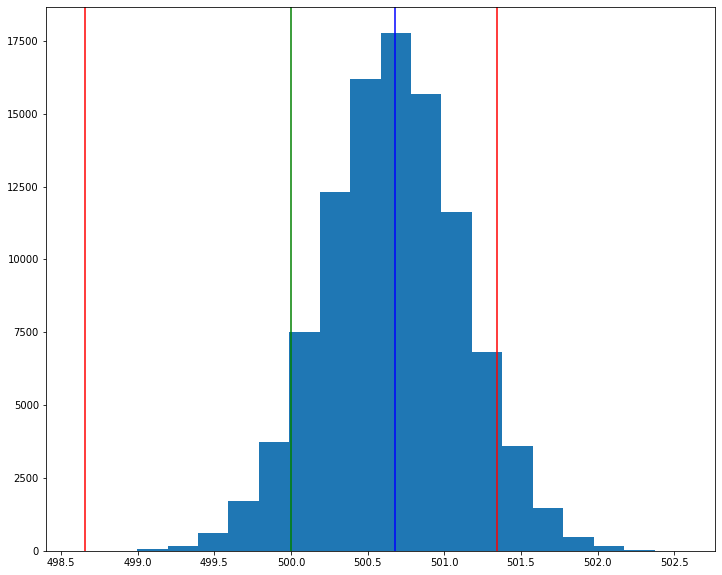

In [ ]:
plt.hist(muitasAmostras2, bins=20)
plt.axvline(x=500,color="green")
plt.axvline(x=limSup,color="red")
plt.axvline(x=limInf,color="red")
plt.axvline(x=500.01+1.5*desvioPadrao,color="blue")

No histograma acima, fica claro que boa parte das amostras obtidas ainda estariam dentro dos limites de controle originais do processo. Na verdade, podemos calcular exatamente quantas amostras cairam fora:

In [ ]:
filtro = filter(lambda amostra: amostra < limSup, muitasAmostras2)
filtro = filter(lambda amostra: amostra > limInf, filtro)
filtro = list(filtro)
print(round(100-(len(filtro)/len(muitasAmostras2)*100),2),"%")

6.6 %


Ou seja, apenas 6,6% das amostras realizadas cairiam fora dos limites. Para melhor compreender isso, podemos traçar um gráfico de poder do nosso gráfico de controle.

In [ ]:
def alarmeVerdadeiro(nvMedia,limSup,limInf,desvioPadrao):
  lsc = norm.cdf(limSup,nvMedia,desvioPadrao)
  lic = norm.cdf(limInf,nvMedia,desvioPadrao)
  beta = (lsc-lic)
  poder = 1 - beta
  CMS = 1/poder
  d = {"beta":beta,
       "poder":poder,
       "cms":CMS}
  return d

In [ ]:
nvMedia = 500.5
alarmeVerdadeiro(nvMedia,limSup,limInf,desvioPadrao)

{'beta': 0.970070311116786,
 'cms': 33.41164032482968,
 'poder': 0.029929688883214012}

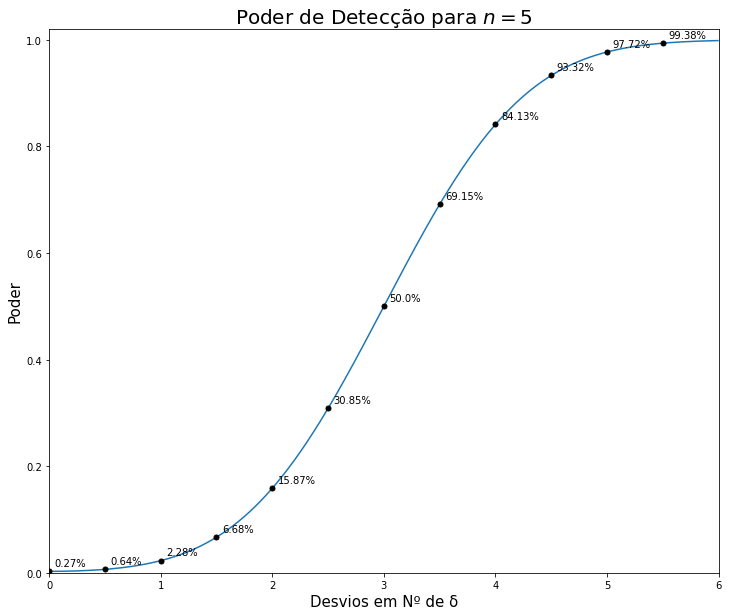

In [ ]:
poder = []
desloc = []
for deslocamento in range(0,1000):
  novaMedia = 500+(deslocamento*((desvioPadrao*6)/1000))
  desloc.append((novaMedia-500)/desvioPadrao)
  poder.append(alarmeVerdadeiro(novaMedia,
                                limSup,limInf,desvioPadrao)["poder"])

plt.plot(desloc,poder)
plt.xlim(0,6)
plt.ylim(0,1.02)
plt.title("Poder de Detecção para $n = 5$",fontsize=20)
plt.xlabel("Desvios em Nº de δ",fontsize=15)
plt.ylabel("Poder",fontsize=15)
for p in range (0,12):
  ponto = p/2
  plt.plot(ponto,
           alarmeVerdadeiro(500+ponto*desvioPadrao,
                            limSup,limInf,desvioPadrao)["poder"],
           marker="o",markersize=5,color="black")
  plt.annotate(s=str(np.round(alarmeVerdadeiro(500+ponto*desvioPadrao,
                                               limSup,
                                               limInf,
                                               desvioPadrao)["poder"]*100,
                              2))+"%",
               xy=(ponto,alarmeVerdadeiro(500+ponto*desvioPadrao,
                                          limSup,
                                          limInf,
                                          desvioPadrao)["poder"]),
               xytext=(ponto+0.05,alarmeVerdadeiro(500+ponto*desvioPadrao,
                                                   limSup,
                                                   limInf,
                                                   desvioPadrao)["poder"]+0.01))

Esse gráfico representa o poder de detecção em função do número de desvios padrões. Percebemos que para um desvio da média de 3 vezes o desvio padrão, a chance de detectarmos um ponto fora do limite de controle é de 50%, ou seja, metade dos pontos cairiam dentro dos limites e metade fora. De fato, para o desvio que vimos anteriormente, de 1,5, o número de 6,6% aparece novamente.

Um último gráfico pode demonstrar qual a probabilidade de cometermos um erro do tipo II para cada valor de nova média do nosso processo de fabricação de milhos de pipoca.

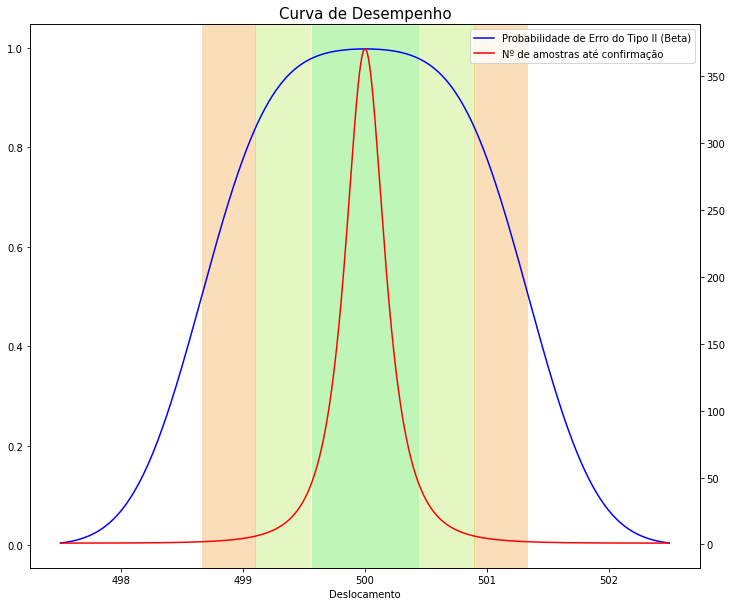

In [ ]:
grafBeta = []
grafDesloc = []
grafCMS = []
for deslocamento in range(0,2000):
  novaMedia = 497.5+(deslocamento*0.0025)
  grafDesloc.append(novaMedia)
  grafBeta.append(alarmeVerdadeiro(novaMedia,
                                   limSup,
                                   limInf,
                                   desvioPadrao)["beta"])
  grafCMS.append(alarmeVerdadeiro(novaMedia,
                                  limSup,
                                  limInf,
                                  desvioPadrao)["cms"])

plt.axvline(500,color="#2ee312",linewidth=107,alpha=.3)

plt.axvline(500+3/2*desvioPadrao,color="#a6e637",linewidth=56,alpha=.3)
plt.axvline(500-3/2*desvioPadrao,color="#a6e637",linewidth=56,alpha=.3)

plt.axvline(500+5/2*desvioPadrao,color="#f0901a",linewidth=54,alpha=.3)
plt.axvline(500-5/2*desvioPadrao,color="#f0901a",linewidth=54,alpha=.3)

ax1 = plt.subplot()
l1, = ax1.plot(grafDesloc,grafBeta, color="blue")
ax2 = ax1.twinx()
l2, = ax2.plot(grafDesloc,grafCMS, color="red")


plt.title("Curva de Desempenho",fontsize=15)
ax1.set_xlabel("Deslocamento")
plt.legend([l1, l2],
           ["Probabilidade de Erro do Tipo II (Beta)",
            "Nº de amostras até confirmação"])

plt.show()

Aqui temos o número esperado de amostras até que um ponto caia fora dos limites de controle, além da probabilidade de cometermos um erro do tipo II para cada desvio da média.